# Projeto de análise de dados do Titanic
O objetivo deste projeto é analisar os dados do Titanic e tentar responder algumas perguntas sobre o naufrágio do navio. Para isso, utilizaremos a biblioteca Pandas para manipulação dos dados e a biblioteca Matplotlib para visualização dos dados. Para modelagem dos dados, utilizaremos a biblioteca Scikit-Learn.

In [34]:
import pandas as pd


In [35]:
def preparedata(df):
    from sklearn.preprocessing import MinMaxScaler
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_age_mean = df.groupby('Title')['Age'].mean()
    title_age_mean = title_age_mean.to_dict()
    df['Age'] = df.apply(lambda x: title_age_mean[x['Title']] if pd.isnull(x['Age']) else x['Age'], axis=1)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Sex'] = (df['Sex']=='female').astype(int)
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Title'], axis=1, inplace=True)
    q3 = df['Fare'].quantile(0.75)
    df.loc[df['Fare'] > q3, 'Fare'] = q3
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    scaler = MinMaxScaler()
    df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])
    return df

In [36]:
def grafbarscores(*scores):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    warnings.filterwarnings('ignore')
    df_scores = pd.DataFrame(columns=['Model', 'Score'])
    for score in scores:
        new_row = {'Model': score[0], 'Score': score[1]}
        df_scores = df_scores.append(new_row, ignore_index=True)
    fig, ax = plt.subplots()
    sns.barplot(x='Score', y='Model', data=df_scores.sort_values(by='Score', ascending=False), ax=ax)
    ax.set_xlim([0, 1])
    for p in ax.patches:
        ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+0.65), xytext=(5, 10), textcoords='offset points')
    plt.xlabel('Score (accuracy)')
    plt.ylabel('Model')
    plt.title('Machine Learning Model Scores')
    plt.show()

In [37]:
df_train = preparedata(pd.read_csv('./data/raw/train.csv'))
df_train.to_csv('./data/processed/second_train.csv', index=False)
df_test_pred = preparedata(pd.read_csv('./data/raw/test.csv'))
df_test = pd.read_csv('./data/raw/test.csv')
df_test_pred.to_csv('./data/processed/second_test.csv', index=False)

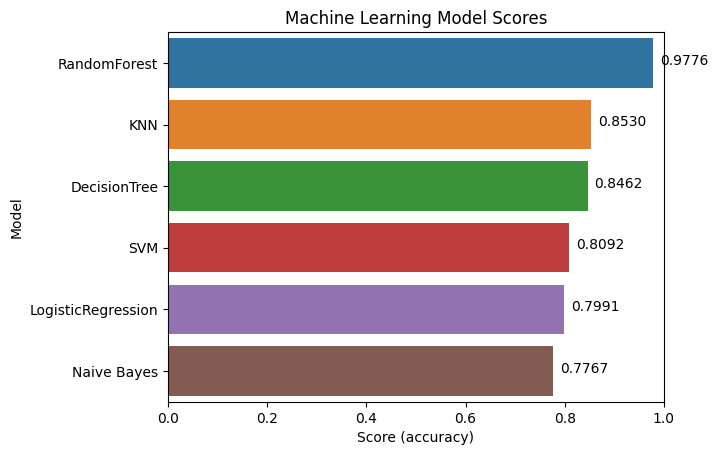

In [38]:
# vamos aplicar o modelo de machine learning: Decision Tree, Random Forest, Logistic Regression, KNN, SVM, Naive Bayes sem separar os dados em treino e teste
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.naive_bayes import GaussianNB

models = []
models.append(('DecisionTree', DecisionTreeClassifier(max_depth=4)))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(C=1, kernel='rbf', gamma=0.1)))
models.append(('Naive Bayes', GaussianNB()))

results = []
names = []
for name, model in models:
    model.fit(df_train.drop('Survived', axis=1), df_train['Survived'])
    result = model.score(df_train.drop('Survived', axis=1), df_train['Survived'])
    results.append(result)
    names.append(name)
    df_test['Survived'] = model.predict(df_test_pred)
    df_test[['PassengerId', 'Survived']].to_csv('./data/submission/second_' + name + '.csv', index=False)

grafbarscores(*zip(names, results))
